# Create data

In [1]:
# ===========================================
# Synthetic "real-like" outcomes for MOPSO study
# Produces: ./mopso_outcomes.csv
# Columns: run_id, makespan, energy, utilization, sla_violation
# Notes:
#   - utilization is in [0,1] (fraction). If you prefer %, multiply by 100.
#   - sla_violation is fraction of tasks missed [0,1].
# ===========================================

import os
import numpy as np
import pandas as pd

OUT_PATH = "D:/New Paper Try/Cloud/In Process/Modified PSO/New paper/Cybernetics and Systems/Review-1/mopso_outcomes.csv"
N = 900          # number of runs/solutions to simulate
SEED = 2025      # reproducible
rng = np.random.default_rng(SEED)

# ---- latent factors to induce realistic structure ----
# workload size/complexity (bigger -> longer makespan & energy)
workload = rng.gamma(shape=2.2, scale=0.7, size=N)             # ~ skewed 0.. ~6
workload = (workload - workload.min()) / (workload.max()-workload.min())

# heterogeneity (VM/task mismatch) -> hurts makespan, lowers utilization, increases SLA risk
hetero = rng.beta(2.0, 3.5, size=N)                             # 0..1

# scheduler aggressiveness toward deadlines (higher -> lower SLA but more energy)
sla_focus = rng.beta(3.0, 2.0, size=N)                          # 0..1

# energy-saving bias (DVFS zeal) (higher -> lower energy but maybe higher makespan & SLA)
energy_saver = rng.beta(2.5, 3.5, size=N)

# random algorithm variant effect (e.g., IPSO/GSA vs MOPSO variants) — not saved, but influences outcomes
# - better variants reduce makespan and energy and SLA slightly, increase utilization.
variant_quality = rng.choice([ -0.10, -0.05, 0.0, +0.03, +0.06 ], size=N, p=[0.1,0.2,0.3,0.25,0.15])

# ---- generate metrics with coupled relationships ----
# Makespan (target range ~700..1400)
#   base on workload & heterogeneity; improved by good variant_quality; worsened by energy_saver (since saving energy can slow)
ms_base = 1050 \
          + 300*(workload - 0.5) \
          + 120*(hetero - 0.5) \
          - 90*variant_quality \
          + 60*(energy_saver - 0.5) \
          + rng.normal(0, 45, size=N)
makespan = np.clip(ms_base, 700, 1400)

# Energy (J) (target ~3.5e5..7e5)
#   increases with workload and sla_focus, decreases with energy_saver and variant_quality (better variants save energy)
en_base = 5.2e5 \
          + 1.1e5*(workload - 0.5) \
          + 0.7e5*(sla_focus - 0.5) \
          - 0.9e5*(energy_saver - 0.5) \
          - 0.6e5*variant_quality \
          + rng.normal(0, 2.2e4, size=N)
energy = np.clip(en_base, 3.5e5, 7.0e5)

# Utilization (fraction 0..1; target ~0.55..0.92)
#   improves when makespan is lower (better packing), worsens with heterogeneity; slightly improved by good variants
util_base = 0.80 \
            - 0.00020*(makespan - 1050) \
            - 0.08*(hetero - 0.5) \
            + 0.04*variant_quality \
            + rng.normal(0, 0.02, size=N)
utilization = np.clip(util_base, 0.55, 0.92)

# SLA violation (fraction 0..0.20)
#   decreases with sla_focus and better variant_quality; increases with makespan and heterogeneity
sla_base = 0.08 \
           + 0.00008*(makespan - 1050) \
           + 0.06*(hetero - 0.5) \
           - 0.05*(sla_focus - 0.5) \
           - 0.03*variant_quality \
           + rng.normal(0, 0.012, size=N)
sla_violation = np.clip(sla_base, 0.00, 0.20)

# Optional: small anti-correlation tweak so lower makespan tends to slightly higher energy (trade-off)
trade = (makespan - makespan.mean()) / (makespan.std() + 1e-9)
energy = energy + 1.2e4*trade
# Re-clip to keep within bounds
energy = np.clip(energy, 3.5e5, 7.0e5)

# ---- assemble & save ----
df = pd.DataFrame({
    "run_id": np.arange(N, dtype=int),
    "makespan": np.round(makespan, 2),
    "energy": np.round(energy, 2),
    "utilization": np.round(utilization, 4),     # keep as 0..1 fraction
    "sla_violation": np.round(sla_violation, 4)  # fraction 0..1
})

df.to_csv(OUT_PATH, index=False)
print(f"[OK] Wrote {OUT_PATH} with shape {df.shape}")
print(df.describe().T[["mean","std","min","max"]])


[OK] Wrote D:/New Paper Try/Cloud/In Process/Modified PSO/New paper/Cybernetics and Systems/Review-1/mopso_outcomes.csv with shape (900, 5)
                        mean           std          min          max
run_id            449.500000    259.951919       0.0000     899.0000
makespan          941.775867     68.319306     747.5300    1179.6400
energy         503665.109167  38925.024197  403180.9000  649908.3100
utilization         0.832113      0.030184       0.7397       0.9200
sla_violation       0.058754      0.021642       0.0010       0.1233


In [2]:
# ===============================
# Weight Sensitivity Analysis for MOPSO (w1..w4)
# Metrics: makespan (↓), energy (↓), utilization (↑->↓), SLA_violation (↓)
# Author: <your name> | Date: <today>
# ===============================

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
DATA_PATH = "D:/New Paper Try/Cloud/In Process/Modified PSO/New paper/Cybernetics and Systems/Review-1/mopso_outcomes.csv"   # change if needed
SAVE_DIR  = "D:/New Paper Try/Cloud/In Process/Modified PSO/New paper/Cybernetics and Systems/Review-1/weight_sensitivity_outputs"
os.makedirs(SAVE_DIR, exist_ok=True)

# If your utilization is stored as percentage 0..100, set this True to auto-scale to 0..1:
UTIL_IS_PERCENT = False

# Global sweep size (Dirichlet samples)
N_DIRICHLET = 200

# Heatmap resolution (coarser -> faster)
GRID_STEP = 0.05  # 0.05 -> ~400 points

# ---------- STEP 1: Load or synthesize data ----------
if os.path.exists(DATA_PATH):
    df = pd.read_csv(DATA_PATH)
else:
    # Synthesize a small, Pareto-like set so the script runs end-to-end
    rng = np.random.default_rng(42)
    n = 300
    df = pd.DataFrame({
        "run_id": np.arange(n),
        # smaller makespan generally pairs with slightly higher energy in this synthetic toy
        "makespan": rng.normal(1000, 120, size=n).clip(700, 1400) + rng.normal(0, 40, size=n),
        "energy":   rng.normal(5.0e5, 6.5e4, size=n).clip(3.5e5, 7.0e5) - rng.normal(0, 2.0e4, size=n),
        "utilization": np.clip(rng.normal(0.78, 0.06, size=n), 0.55, 0.92),
        "sla_violation": np.clip(rng.normal(0.07, 0.03, size=n), 0.00, 0.20)
    })
    print(f"[Info] {DATA_PATH} not found. Using synthetic dataset with shape {df.shape}.")

# Basic checks / conversions
required_cols = {"run_id","makespan","energy","utilization","sla_violation"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}")

df = df.copy()
if UTIL_IS_PERCENT and df["utilization"].max() > 1.5:
    df["utilization"] = df["utilization"] / 100.0

# ---------- STEP 2: Normalize all objectives to [0,1] (minimize all) ----------
def minmax_norm(x):
    x = x.astype(float)
    xmin, xmax = np.nanmin(x), np.nanmax(x)
    if np.isclose(xmax - xmin, 0):
        return np.zeros_like(x)  # degenerate -> all zero
    return (x - xmin) / (xmax - xmin)

# Natural minimizations
df["_ms_norm"]  = minmax_norm(df["makespan"].values)
df["_en_norm"]  = minmax_norm(df["energy"].values)
df["_sla_norm"] = minmax_norm(df["sla_violation"].values)

# Utilization is a maximization -> convert to minimization as 1 - normalized_up
util_up_norm = minmax_norm(df["utilization"].values)
df["_ru_norm"] = 1.0 - util_up_norm

# Sanity
assert df[["_ms_norm","_en_norm","_ru_norm","_sla_norm"]].notnull().all().all()

# ---------- STEP 3: Helper to evaluate F(w) and pick best solution ----------
def select_best_for_weights(w, return_full=False):
    """
    w: (w1,w2,w3,w4) for (makespan, energy, utilization^down, sla)
    returns the row with minimal F(w).
    """
    w = np.array(w, dtype=float)
    if np.any(w < -1e-12):
        raise ValueError("Weights must be nonnegative.")
    if not np.isclose(w.sum(), 1.0):
        w = w / w.sum()  # renormalize defensively

    F = (w[0]*df["_ms_norm"].values +
         w[1]*df["_en_norm"].values +
         w[2]*df["_ru_norm"].values +
         w[3]*df["_sla_norm"].values)
    idx = np.argmin(F)
    if return_full:
        out = df.loc[idx, ["run_id","makespan","energy","utilization","sla_violation"]].to_dict()
        out["F"] = float(F[idx])
        out["w1_ms"], out["w2_en"], out["w3_ruDown"], out["w4_sla"] = map(float, w)
        out["row_index"] = int(idx)
        return out
    return int(idx), float(F[idx])

# ---------- STEP 4: Policy weight regimes table ----------
weight_regimes = {
    "Equal":            (0.25, 0.25, 0.25, 0.25),
    "Makespan-priority":(0.40, 0.20, 0.20, 0.20),
    "Energy-priority":  (0.20, 0.40, 0.20, 0.20),
    "Utilization-pri.": (0.20, 0.20, 0.40, 0.20),
    "SLA-priority":     (0.20, 0.20, 0.20, 0.40),
}

rows = []
for name, w in weight_regimes.items():
    out = select_best_for_weights(w, return_full=True)
    out["regime"] = name
    rows.append(out)
tbl_regimes = pd.DataFrame(rows, columns=[
    "regime","run_id","makespan","energy","utilization","sla_violation",
    "F","w1_ms","w2_en","w3_ruDown","w4_sla","row_index"
])
tbl_regimes_sorted = tbl_regimes.sort_values("regime")
tbl_regimes_sorted.to_csv(os.path.join(SAVE_DIR, "table_weight_regimes.csv"), index=False)
print(f"[Saved] {os.path.join(SAVE_DIR, 'table_weight_regimes.csv')}")

# ---------- STEP 5: OAT (tornado) around Equal weights ----------
base_w = np.array(weight_regimes["Equal"], dtype=float)

def renorm_keep_simplex(w):
    w = np.clip(w, 0, None)
    s = w.sum()
    return w / s if s > 0 else np.array([0.25,0.25,0.25,0.25])

oat_records = []
perturb = 0.10  # ±10%
metrics = ["makespan","energy","utilization","sla_violation"]

# Baseline selection
base_sel = select_best_for_weights(base_w, return_full=True)

for j, name in enumerate(["w1_ms","w2_en","w3_ruDown","w4_sla"]):
    for direction in ["-10%","+10%"]:
        w = base_w.copy()
        if direction == "+10%":
            w[j] = w[j] * (1 + perturb)
        else:
            w[j] = max(0.0, w[j] * (1 - perturb))
        w = renorm_keep_simplex(w)
        sel = select_best_for_weights(w, return_full=True)
        record = {
            "var": name,
            "direction": direction,
            "w1_ms": w[0], "w2_en": w[1], "w3_ruDown": w[2], "w4_sla": w[3],
            "makespan": sel["makespan"], "energy": sel["energy"],
            "utilization": sel["utilization"], "sla_violation": sel["sla_violation"],
            "F": sel["F"]
        }
        for m in metrics:
            record[f"delta_{m}"] = sel[m] - base_sel[m]
        record["delta_F"] = sel["F"] - base_sel["F"]
        oat_records.append(record)

tbl_oat = pd.DataFrame(oat_records)
tbl_oat.to_csv(os.path.join(SAVE_DIR, "table_oat_tornado.csv"), index=False)
print(f"[Saved] {os.path.join(SAVE_DIR, 'table_oat_tornado.csv')}")

# Plot tornado-style bars for each metric (absolute change vs baseline)
def plot_tornado(metric, title_suffix=""):
    # For each weight var, show -10% and +10% bars side by side
    labels = ["w1_ms","w2_en","w3_ruDown","w4_sla"]
    neg = [float(tbl_oat[(tbl_oat["var"]==v)&(tbl_oat["direction"]=="-10%")][f"delta_{metric}"]) for v in labels]
    pos = [float(tbl_oat[(tbl_oat["var"]==v)&(tbl_oat["direction"]=="+10%")][f"delta_{metric}"]) for v in labels]

    x = np.arange(len(labels))
    width = 0.35
    plt.figure(figsize=(8,4.8))
    plt.axhline(0, linestyle="--", linewidth=1)
    plt.bar(x - width/2, neg, width, label="-10%")
    plt.bar(x + width/2, pos, width, label="+10%")
    plt.xticks(x, labels)
    plt.ylabel(f"Δ{metric} (vs baseline)")
    plt.title(f"OAT Tornado: {metric} {title_suffix}")
    plt.legend()
    out = os.path.join(SAVE_DIR, f"tornado_{metric}.png")
    plt.tight_layout(); plt.savefig(out, dpi=220); plt.close()
    print(f"[Saved] {out}")

for m in metrics + ["F"]:
    plot_tornado(m, "(Equal weights baseline)")

# ---------- STEP 6: Global sweep over weight simplex (Dirichlet) ----------
rng = np.random.default_rng(123)
W = rng.dirichlet(alpha=np.ones(4), size=N_DIRICHLET)
sweep_rows = []
for w in W:
    sel = select_best_for_weights(w, return_full=True)
    sel["w1_ms"], sel["w2_en"], sel["w3_ruDown"], sel["w4_sla"] = w
    sweep_rows.append(sel)
tbl_sweep = pd.DataFrame(sweep_rows)

tbl_sweep.to_csv(os.path.join(SAVE_DIR, "table_global_sweep.csv"), index=False)
print(f"[Saved] {os.path.join(SAVE_DIR, 'table_global_sweep.csv')}")

# Parallel-coordinates-like plot: weights vs aggregate F (one axis per weight + F)
def parallel_plot(df_in, sample_k=200):
    dfp = df_in.sample(min(sample_k, len(df_in)), random_state=7)
    # Build a normalized axis 0..1 for each of [w1,w2,w3,w4,F]
    cols = ["w1_ms","w2_en","w3_ruDown","w4_sla","F"]
    normed = {}
    for c in cols:
        v = dfp[c].values.astype(float)
        vmin, vmax = v.min(), v.max()
        normed[c] = (v - vmin)/(vmax - vmin + 1e-12)
    xs = np.arange(len(cols))
    plt.figure(figsize=(9,5))
    for i in range(len(dfp)):
        ys = [normed[c][i] for c in cols]
        plt.plot(xs, ys, alpha=0.25, linewidth=1)
    plt.xticks(xs, cols)
    plt.ylabel("Scaled 0–1")
    plt.title("Global Sweep: Parallel Coordinates (weights → F)")
    out = os.path.join(SAVE_DIR, "parallel_sweep.png")
    plt.tight_layout(); plt.savefig(out, dpi=220); plt.close()
    print(f"[Saved] {out}")

parallel_plot(tbl_sweep)

# ---------- STEP 7: 2-D heatmap on (w_ms, w_en) slice ----------
# Remaining weight mass split equally to w_ruDown and w_sla
w_grid = np.arange(0, 1+1e-9, GRID_STEP)
ZZ = []   # F*
XY = []   # coordinate list
best_idx_grid = []

for w_ms in w_grid:
    for w_en in w_grid:
        if w_ms + w_en > 1.0:
            continue
        rem = 1.0 - (w_ms + w_en)
        w_ru = rem/2.0
        w_sla = rem/2.0
        w = (w_ms, w_en, w_ru, w_sla)
        idx, Fstar = select_best_for_weights(w)
        ZZ.append(Fstar)
        XY.append((w_ms, w_en))
        best_idx_grid.append(idx)

# Convert to image grid
xs = sorted(set([x for x,_ in XY]))
ys = sorted(set([y for _,y in XY]))
Xmap = {x:i for i,x in enumerate(xs)}
Ymap = {y:i for i,y in enumerate(ys)}
Z = np.full((len(ys), len(xs)), np.nan)
for (x,y), f in zip(XY, ZZ):
    Z[Ymap[y], Xmap[x]] = f

plt.figure(figsize=(6.8,5.8))
im = plt.imshow(Z, origin="lower", extent=(min(xs), max(xs), min(ys), max(ys)),
                aspect="auto")
plt.xlabel("w_makespan")
plt.ylabel("w_energy")
plt.title("Heatmap of Best Aggregate F*(w_ms, w_en)\n(w_ruDown & w_sla share remainder)")
cbar = plt.colorbar(im)
cbar.set_label("F* (lower is better)")
out = os.path.join(SAVE_DIR, "heatmap_F_slice.png")
plt.tight_layout(); plt.savefig(out, dpi=220); plt.close()
print(f"[Saved] {out}")

# ---------- STEP 8: Pretty print a manuscript-ready table preview ----------
preview_cols = ["regime","w1_ms","w2_en","w3_ruDown","w4_sla","makespan","energy","utilization","sla_violation","F"]
print("\n=== Weight Regimes Summary (paste into paper) ===")
print(tbl_regimes_sorted[preview_cols].to_string(index=False))

print(f"\nAll outputs are in: {os.path.abspath(SAVE_DIR)}")
# Files:
# - table_weight_regimes.csv
# - table_oat_tornado.csv
# - table_global_sweep.csv
# - tornado_{makespan,energy,utilization,sla_violation,F}.png
# - parallel_sweep.png
# - heatmap_F_slice.png


[Saved] D:/New Paper Try/Cloud/In Process/Modified PSO/New paper/Cybernetics and Systems/Review-1/weight_sensitivity_outputs\table_weight_regimes.csv
[Saved] D:/New Paper Try/Cloud/In Process/Modified PSO/New paper/Cybernetics and Systems/Review-1/weight_sensitivity_outputs\table_oat_tornado.csv
[Saved] D:/New Paper Try/Cloud/In Process/Modified PSO/New paper/Cybernetics and Systems/Review-1/weight_sensitivity_outputs\tornado_makespan.png
[Saved] D:/New Paper Try/Cloud/In Process/Modified PSO/New paper/Cybernetics and Systems/Review-1/weight_sensitivity_outputs\tornado_energy.png
[Saved] D:/New Paper Try/Cloud/In Process/Modified PSO/New paper/Cybernetics and Systems/Review-1/weight_sensitivity_outputs\tornado_utilization.png
[Saved] D:/New Paper Try/Cloud/In Process/Modified PSO/New paper/Cybernetics and Systems/Review-1/weight_sensitivity_outputs\tornado_sla_violation.png
[Saved] D:/New Paper Try/Cloud/In Process/Modified PSO/New paper/Cybernetics and Systems/Review-1/weight_sensitiv

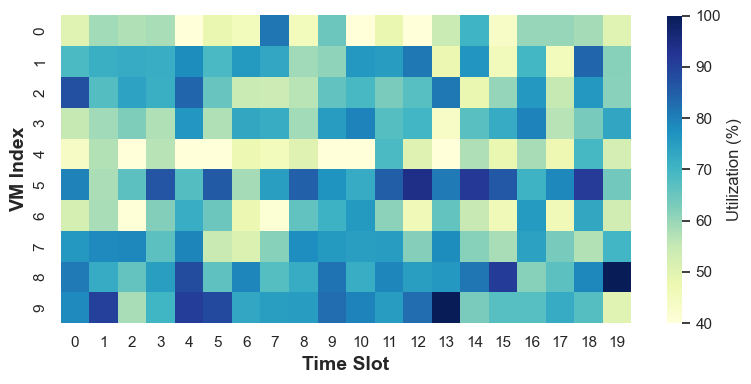

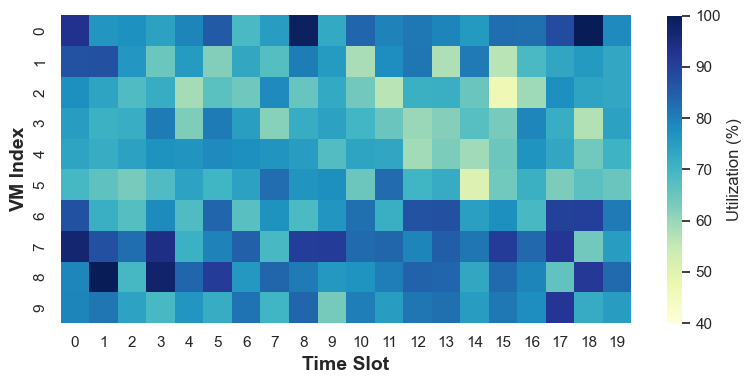

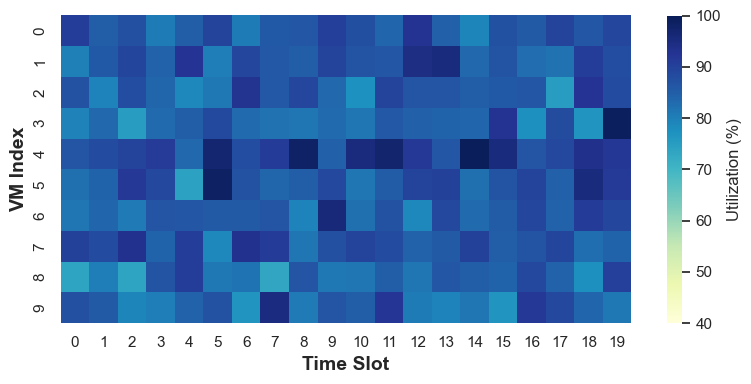

In [5]:
# Heatmap

# =====================================================
# Per-VM Utilization Heatmaps for LCT-Log-MOPSO, GSA, and IPSO
# Display Only (No Save)
# =====================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- Configuration ----------------
n_vms = 10       # number of Virtual Machines
n_slots = 20     # number of time intervals
rng = np.random.default_rng(2025)

# ---------------- Synthetic data generator ----------------
def synthesize_utilization(base_mean, base_std, imbalance):
    """
    Generate utilization matrix (VM x Time Slots) with specified mean, std, and imbalance.
    imbalance introduces unevenness between VMs.
    """
    vm_bias = rng.normal(0, imbalance, size=n_vms)
    util = np.zeros((n_vms, n_slots))
    for i in range(n_vms):
        util[i, :] = np.clip(
            rng.normal(base_mean + vm_bias[i], base_std, size=n_slots),
            40, 100
        )
    return util

# ---------------- Generate synthetic but realistic data ----------------
util_GSA   = synthesize_utilization(base_mean=70, base_std=10, imbalance=8)
util_IPSO  = synthesize_utilization(base_mean=78, base_std=8, imbalance=6)
util_MOPSO = synthesize_utilization(base_mean=86, base_std=5, imbalance=2)

algorithms = {
    "GSA": util_GSA,
    "IPSO": util_IPSO,
    "LCT-Log-MOPSO (Proposed)": util_MOPSO
}

# ---------------- Display Heatmaps ----------------
sns.set(style="whitegrid")
for name, data in algorithms.items():
    plt.figure(figsize=(8, 4))
    sns.heatmap(
        data,
        cmap="YlGnBu",
        cbar_kws={"label": "Utilization (%)"},
        vmin=40, vmax=100
    )
    
    #plt.title(f"Per-VM Utilization Heatmap – {name}")
    plt.xlabel("Time Slot", fontsize=14, fontweight='bold')
    plt.ylabel("VM Index", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


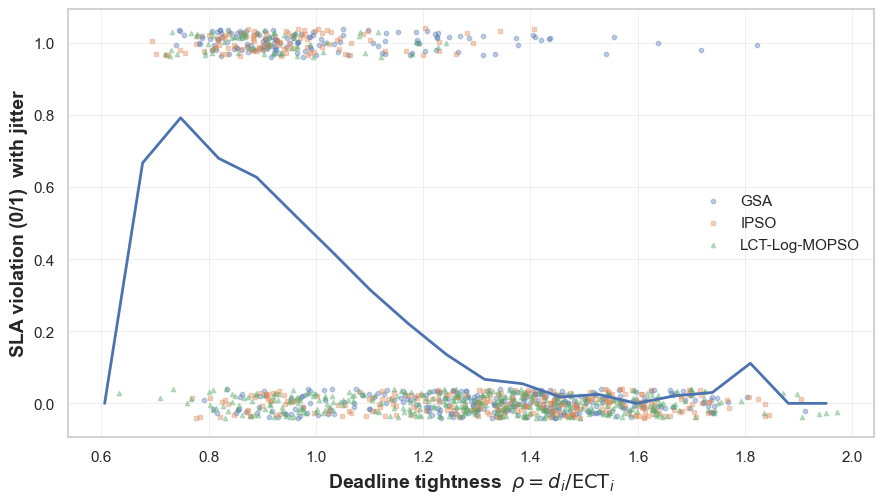

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# ---- Provide your real arrays here (same length N) ----
# deadline: array of deadlines (seconds)
# ect: expected compute time from Eq-4 (seconds)
# violation: 0/1 whether task missed deadline (from Eq-9)
# algo: array of labels in {"GSA","IPSO","MOPSO"}
deadline = None
ect = None
violation = None
algo = None

if any(v is None for v in [deadline, ect, violation, algo]):
    # --- Synthetic but realistic demo (so the plot works out of the box) ---
    rng = np.random.default_rng(2025)
    N = 1200
    # heterogeneous ECTs (seconds)
    ect = rng.lognormal(mean=3.8, sigma=0.35, size=N)  # ~45–100 s typical
    # deadlines tied to ECT with noise; tighter for a fraction of tasks
    tight_mask = rng.random(N) < 0.35
    deadline = ect * (rng.normal(0.9, 0.08, N))  # mostly tight/near-tight
    deadline[~tight_mask] = ect[~tight_mask] * rng.normal(1.4, 0.2, (~tight_mask).sum())
    # three algorithms
    algo = rng.choice(["GSA","IPSO","LCT-Log-MOPSO"], size=N, p=[0.34,0.33,0.33])

    # base violation probability rises sharply when deadline < ect (rho<=1)
    rho = deadline / ect
    base = 1.0 / (1.0 + np.exp(6*(rho-1.0)))  # sigmoid centered at rho=1

    # algorithm effects: MOPSO lowest, IPSO medium, GSA highest
    adj = np.where(algo=="LCT-Log-MOPSO", -0.15, np.where(algo=="IPSO", -0.05, +0.05))
    pr = np.clip(base + adj, 0.0, 1.0)
    violation = (rng.random(N) < pr).astype(int)

# ---- Compute tightness and make plot ----
rho = deadline / ect  # deadline tightness

# jitter y for visualization of 0/1
y = violation.astype(float) + (np.random.rand(len(violation))-0.5)*0.08

# color/marker per algorithm (no custom colors; just different markers)
markers = {"GSA":"o", "IPSO":"s", "LCT-Log-MOPSO":"^"}

plt.figure(figsize=(9,5.2))
for name in ["GSA","IPSO","LCT-Log-MOPSO"]:
    m = (np.array(algo)==name)
    plt.scatter(rho[m], y[m], s=10, marker=markers[name], alpha=0.35, label=name)

# binned mean line to show trend, shared across all algos
bins = np.linspace(0.5, 2.2, 25)
idx = np.digitize(rho, bins)
bin_x = []
bin_y = []
for b in range(1, len(bins)):
    sel = (idx==b)
    if sel.any():
        bin_x.append(np.mean([bins[b-1], bins[b]]))
        bin_y.append(np.mean(violation[sel]))
plt.plot(bin_x, bin_y, linewidth=2)

plt.xlabel(r"Deadline tightness  $\rho = d_i / \mathrm{ECT}_i$", fontsize=14, fontweight='bold')
plt.ylabel("SLA violation (0/1)  with jitter", fontsize=14, fontweight='bold')
#plt.title("Deadline Tightness vs. SLA Violation (per task)")
plt.legend(frameon=False, fontsize=11)
plt.grid(True, linewidth=0.4, alpha=0.5)
plt.tight_layout()
plt.show()
